In [1]:
import dns
import numpy as np
from pathlib import Path
from scipy import optimize as opt
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

In [2]:
Ry = True
statesdir = Path("/home/gokhan/projects/dnsbox/re150Lx32Lz16")
savedir = Path("/home/gokhan/projects/dnsbox/re150Lx32Lz16")

In [3]:
state_, header_ = dns.readState(statesdir / "state.000000")
forcing, nx, ny, nz, Lx, Lz, Re, tilt_angle, dt, itime, time = header_
ny_half = ny // 2

In [4]:
if Ry and ny_half % 2 != 0:
    exit("Ry but ny_half is not even.")

In [8]:
def find_shift(projection):
    shift = (np.arctan2(projection.imag, projection.real) / (2 * np.pi)) % 1
    return shift

def find_dphases(projections, times):
    shifts = find_shift(projections)
    phases = np.unwrap(shifts * 2 * np.pi)
    dts = times[1:] - times[:-1]
    dphases = (phases[1:] - phases[:-1]) / dts
    return dphases

def constraint_unit_template(coeffs):
    return np.sqrt(np.sum(coeffs**2))

def maximize_average(coeffs, projs):
    res = np.einsum("ij,j",projs,coeffs,dtype=np.complex128)
    abs_res = np.abs(res)
    return -np.sqrt(np.average(abs_res**2))

In [15]:
def optimal_template(projections,str_projections,times,verbose=1,maxiter=1000):
    
    tag = f"{str_projections}"
    print(tag)
    
    nstates, ncoeffs = projections.shape
    x0 = np.ones((ncoeffs))/np.sqrt(ncoeffs)
    
    constraints = opt.NonlinearConstraint(constraint_unit_template,1,1)
    
    # run the optimization
    opts = opt.minimize(maximize_average,x0,args=(projections,),method="trust-constr",
                        constraints=constraints,
                        options={"verbose": verbose, "maxiter": maxiter})
    
    coeffs = opts.x
    
    # save coefficients
    np.savetxt(savedir / f"coeffs_{tag}.gp", coeffs)
    
    # save template
    template = np.zeros((nx, ny_half, nz, 3), dtype=np.complex128)
    if Ry:
        if str_projections == "x":
            template[1,1:,0,0] = coeffs[:ny_half-1] / 4
            template[-1,1:,0,0] = coeffs[:ny_half-1] / 4
            
            template[1,1:,0,1] = -1j*coeffs[ny_half-1:2*ny_half-2] / 4
            template[-1,1:,0,1] = -1j*coeffs[ny_half-1:2*ny_half-2] / 4
            
            template[1,:,0,2] = coeffs[2*ny_half-2:] / 4
            template[-1,:,0,2] = coeffs[2*ny_half-2:] / 4

        elif str_projections == "z":
            template[0,:,1,0] = coeffs[:ny_half] / 4
            template[0,:,-1,0] = coeffs[:ny_half] / 4

            template[0,1:,1,1] = -1j*coeffs[ny_half:2*ny_half-1] / 4
            template[0,1:,-1,1] = -1j*coeffs[ny_half:2*ny_half-1] / 4

            template[0,1:,1,2] = coeffs[2*ny_half-1:] / 4
            template[0,1:,-1,2] = coeffs[2*ny_half-1:]/ 4
    else:
        exit("Not yet implemented.")
    
            
    dns.writeState_nocompact(template,forcing=forcing,Lx=Lx,Lz=Lz,Re=Re,tilt_angle=tilt_angle,dt=dt,
                   outFile = savedir / f"u_{str_projections}p.000000")

    projections_opt = np.einsum("ij,j",projections,coeffs,dtype=np.complex128)
    dphases = find_dphases(projections_opt, times)

    fig, ax = plt.subplots()
    ax.plot(times, np.abs(projections_opt))
    ax.set_xlabel("$t$")
    ax.set_ylabel(f"$|p_{str_projections}|$")
    ax.set_xlim(left=times[0], right=times[-1])
    fig.savefig(savedir / f"p{tag}.png", bbox_inches="tight")

    # Plot phase derivatives
    fig, ax = plt.subplots()
    ax.plot(times[:-1], dphases)
    ax.set_xlabel("$t$")
    ax.set_ylabel(f"$\\dot{{\\phi_{str_projections}}}$")
    ax.set_xlim(left=times[0], right=times[-2])
    fig.savefig(savedir / f"dphase_{tag}.png", bbox_inches="tight")
    
    plt.show()

In [13]:
projections_x_runtime_rview = np.loadtxt(statesdir / "slice_projections_x.gp")[:,2:]
projections_z_runtime_rview = np.loadtxt(statesdir / "slice_projections_z.gp")[:,2:]

projections_x_runtime = projections_x_runtime_rview[:,::2] + 1j*projections_x_runtime_rview[:,1:][:,::2]
projections_z_runtime = projections_z_runtime_rview[:,::2] + 1j*projections_z_runtime_rview[:,1:][:,::2]

times_x = np.loadtxt(statesdir / "slice_projections_x.gp")[:,1]
times_z = np.loadtxt(statesdir / "slice_projections_z.gp")[:,1]

x


/home/gokhan/usr/local/anaconda3/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`gtol` termination condition is satisfied.
Number of iterations: 61, function evaluations: 2760, CG iterations: 102, optimality: 7.12e-09, constraint violation: 0.00e+00, execution time: 0.55 s.


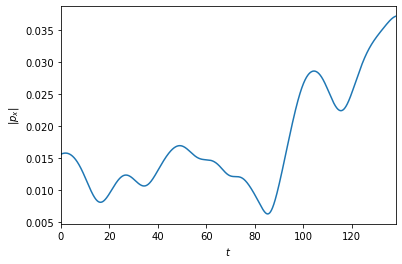

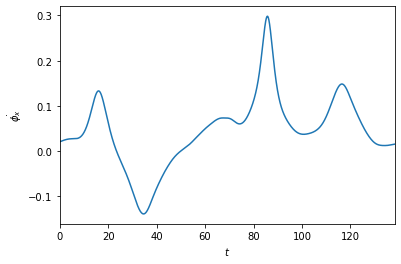

z
`gtol` termination condition is satisfied.
Number of iterations: 15, function evaluations: 414, CG iterations: 14, optimality: 2.18e-09, constraint violation: 1.95e-14, execution time: 0.083 s.


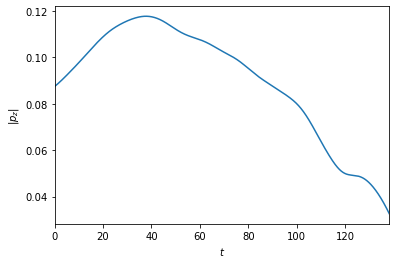

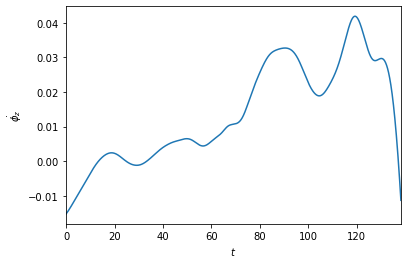

In [16]:
optimal_template(np.conjugate(projections_x_runtime),"x", times_x)
optimal_template(np.conjugate(projections_z_runtime),"z", times_z)

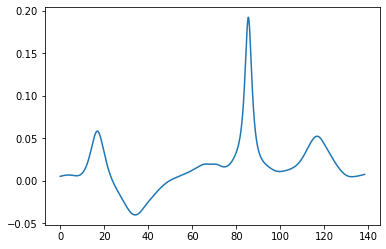

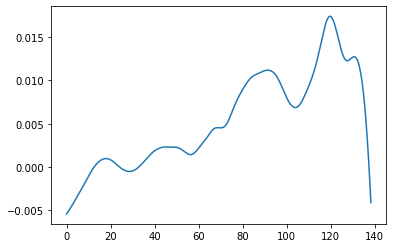

In [20]:
data = np.loadtxt(statesdir / "phases.gp")
times_sim = data[:,1]
phases_x = np.unwrap(data[:,2])
phases_z = np.unwrap(data[:,3])
dt_sim = times_sim[1:] - times_sim[:-1]
dphix = (phases_x[1:] - phases_x[:-1])/dt
dphiz = (phases_z[1:] - phases_z[:-1])/dt

fig, ax = plt.subplots()
ax.plot(times_sim[:-1], dphix)

fig, ax = plt.subplots()
ax.plot(times_sim[:-1], dphiz)